##1. Data

### 1.1 Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/UChicago🏫/ML Final Project 2025"

 BMI.zip  'ML2 Final Project - Task Split up.gdoc'  'ML Final - VGG model'


In [3]:
!mkdir -p /content/data
!unzip "/content/drive/MyDrive/UChicago🏫/ML Final Project 2025/BMI.zip" -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/BMI/Data/Images/img_4108.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_4108.bmp  
  inflating: /content/data/BMI/Data/Images/img_3667.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_3667.bmp  
  inflating: /content/data/BMI/Data/Images/img_2790.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2790.bmp  
  inflating: /content/data/BMI/Data/Images/img_279.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_279.bmp  
  inflating: /content/data/BMI/Data/Images/img_2948.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2948.bmp  
  inflating: /content/data/BMI/Data/Images/img_1299.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_1299.bmp  
  inflating: /content/data/BMI/Data/Images/img_2784.bmp  
  inflating: /content/data/__MACOSX/BMI/Data/Images/._img_2784.bmp  
  inflating: /content/data/BMI/Data/Images/img_523.bmp  
  inf

In [4]:
!ls /content/data/BMI/Data

data.csv  Images


### 1.2 Data Preview

In [5]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
DATA_DIR = '/content/data/BMI/Data'

csv_path = os.path.join(DATA_DIR, 'data.csv')
labels = pd.read_csv(csv_path)
print("Columns:", labels.columns.tolist())
labels.head()

Columns: ['Unnamed: 0', 'bmi', 'gender', 'is_training', 'name']


,Unnamed: 0,bmi,gender,is_training,name
0,0,34.207396,Male,1,img_0.bmp
1,1,26.453720,Male,1,img_1.bmp
2,2,34.967561,Female,1,img_2.bmp
3,3,22.044766,Female,1,img_3.bmp
4,4,37.758789,Female,1,img_4.bmp


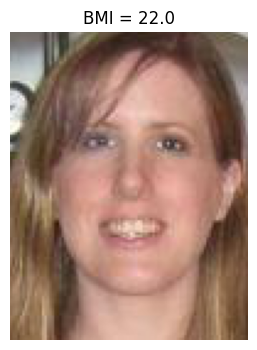

In [7]:
sample = labels.iloc[3]
img_name, bmi_value = sample['name'], sample['bmi']
img_path = os.path.join(DATA_DIR, 'Images', img_name)

img = Image.open(img_path)
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"BMI = {bmi_value:.1f}")
plt.show()

### 1.3 Data Preprocessing

In [2]:
!pip install facenet-pytorch

In [15]:
# !pip uninstall -y pillow
# !pip install pillow==9.5.0

Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 9.5.0 which is incompatible.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.


#### Face Detection and Cropping

In [8]:
from facenet_pytorch import MTCNN
from PIL import Image

In [9]:
mtcnn = MTCNN(image_size=224, margin=20)   # 224×224

INPUT_DIR  = '/content/data/BMI/Data/Images'
OUTPUT_DIR = '/content/data/faces'
os.makedirs(OUTPUT_DIR, exist_ok=True)

for fname in os.listdir(INPUT_DIR):
    img_path = os.path.join(INPUT_DIR, fname)
    img = Image.open(img_path).convert('RGB')
    face = mtcnn(img)   # 3×224×224 Tensor
    if face is not None:
        face_pil = Image.fromarray((face.permute(1,2,0).int().numpy()).astype('uint8'))
        face_pil.save(os.path.join(OUTPUT_DIR, fname))
    else:
        print(f"⚠️ No clear face detected: {fname}")

⚠️ No clear face detected: img_3526.bmp
⚠️ No clear face detected: img_3353.bmp
⚠️ No clear face detected: img_973.bmp
⚠️ No clear face detected: img_1033.bmp
⚠️ No clear face detected: img_3607.bmp
⚠️ No clear face detected: img_59.bmp
⚠️ No clear face detected: img_148.bmp
⚠️ No clear face detected: img_77.bmp


In [10]:
OUTPUT_DIR

'/content/data/faces'

## 2. Model Training 1: VGG16-4096-MLP Regression Model

### 2.1 Feature Extraction

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [10]:
# 1) Pretrained VGG16
base = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
feat_extractor = Model(inputs=base.input, outputs=base.get_layer('fc1').output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [11]:
# 2) Feature Extraction
IMG_COL = 'name'
BMI_COL = 'bmi'

def extract_features(df, images_dir):
    X, y = [], []
    for _, row in df.iterrows():
        img_name = row[IMG_COL]
        img_path = os.path.join(images_dir, img_name)
        if not os.path.exists(img_path):
            print(f"⚠️ Skip {img_name}: no face file")
            continue

        x = preprocess_image(img_path)
        feat = feat_extractor.predict(x).flatten()
        X.append(feat)
        y.append(row[BMI_COL])
    return np.vstack(X), np.array(y)

In [18]:
print(train_df.columns.tolist())

['Unnamed: 0', 'bmi', 'gender', 'is_training', 'name']


### 2.3 Train / Test Split

In [19]:
faces_dir = '/content/data/faces'
X_train, y_train = extract_features(train_df, faces_dir)
X_test,  y_test  = extract_features(test_df,  faces_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
⚠️ Skip img_239.bmp: no face file
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step
⚠️ Skip img_2468.bmp: no face file
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
⚠️ Skip img_1822.bmp: no face file
1/1 ━

### 2.4 A Quick Run - 4096 Features + MLP

#### 2.4.1 Down-sample

In [20]:
# Set SUBSAMPLE = None to use all data
SUBSAMPLE = 300           # e.g. use 300 images for the quick test
VAL_SPLIT = 0.1           # 10 % of the subsample for validation

if SUBSAMPLE is not None:
    idx = np.random.choice(len(X_train), SUBSAMPLE, replace=False)
    X_sub   = X_train[idx]
    y_sub   = y_train[idx]
    # Train/val split inside the subsample
    from sklearn.model_selection import train_test_split
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
        X_sub, y_sub, test_size=VAL_SPLIT, random_state=42)
else:
    X_train_sub, y_train_sub = X_train, y_train
    X_val_sub,   y_val_sub   = None, None        # will rely on validation_split later
print(f"Training on {len(X_train_sub)} samples")

Training on 270 samples


#### 2.4.2 Build the model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [29]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(4096,)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='huber', metrics=['mae'])
model.summary()

history = model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val_sub, y_val_sub) if X_val_sub is not None else (X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[early, reduce],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,229,249 (8.50 MB)

 Trainable params: 2,229,249 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 25.0470 - mae: 25.5457 - val_loss: 5.5440 - val_mae: 6.0262 - learning_rate: 1.0000e-04
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.5449 - mae: 8.0289 - val_loss: 5.6450 - val_mae: 6.1149 - learning_rate: 1.0000e-04
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 6.1974 - mae: 6.6804 - val_loss: 6.1765 - val_mae: 6.6558 - learning_rate: 1.0000e-04
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 6.0885 - mae: 6.5743 - val_loss: 5.5272 - val_mae: 6.0142 - learning_rate: 5.0000e-05
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 6.5981 - mae: 7.0855 - val_loss: 5.4848 - val_mae: 5.9626 - learning_rate: 5.0000e-05
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 6.2867 - mae: 6.7738 - val_loss: 5.7015 - val_mae: 6.1875 - learning_rate: 5.0000e-05
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 6.0692 - mae: 6.5531 - val_loss: 5.6101 - val_mae: 6.1053 - learning_rate: 5.0000e-

#### 2.4.3 Evaluation

In [30]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats     import pearsonr

y_pred = model.predict(X_test).flatten()
mae    = mean_absolute_error(y_test, y_pred)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
r, _   = pearsonr(y_test, y_pred)

print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Pearson r: {r:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MAE : 6.539
Test RMSE: 8.424
Pearson r: 0.045


## 3. Model Training 2: Fine‑tuned VGG16 Regression Head
- VGG16→GAP→Dense(1) Model

#### 3.0 Imports & basic constants

In [11]:
import os, numpy as np, tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

#### 3.1 Preparation
- Build a parse_fn with augmentation
- Create tf.data pipelines (with cache for speed)

In [12]:
import pandas as pd, os

In [13]:
faces_dir = '/content/data/faces'
CSV_PATH  = '/content/data/BMI/Data/data.csv'
IMG_COL, BMI_COL = 'name', 'bmi'

In [24]:
df = pd.read_csv(CSV_PATH)

existing = set(os.listdir(faces_dir))
df = df[df[IMG_COL].isin(existing)].reset_index(drop=True)
print("Available data sample size：", len(df))

y_mean = df['bmi'].mean()
y_std  = df['bmi'].std()

df['BMI_z'] = (df['bmi'] - y_mean) / y_std

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("Train:", len(train_df), " Test:", len(test_df))

✔︎ 可用样本数： 3954
Train: 3163  Test: 791


In [48]:
import tensorflow as tf

In [50]:
def random_cutout(img, mask_size=50):
    """Zero‑out a random mask_size×mask_size patch in img."""
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    y = tf.random.uniform([], 0, h - mask_size, dtype=tf.int32)
    x = tf.random.uniform([], 0, w - mask_size, dtype=tf.int32)

    mask = tf.ones_like(img)

    yy = tf.range(y, y + mask_size)
    xx = tf.range(x, x + mask_size)
    Y, X = tf.meshgrid(yy, xx, indexing='ij')
    coords = tf.stack([
        tf.reshape(Y, [-1]),   # mask_size*mask_size
        tf.reshape(X, [-1])
    ], axis=1)                # shape [mask_size*mask_size, 2]

    updates = tf.zeros([mask_size * mask_size, 3], dtype=img.dtype)
    mask = tf.tensor_scatter_nd_update(mask, coords, updates)

    return img * mask


BATCH_SIZE = 64

def parse_fn(path, label, training):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, (224,224))

    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = random_cutout(img, mask_size=50)

    img = tf.keras.applications.vgg16.preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(df, training):
    paths  = [os.path.join(faces_dir, f) for f in df[IMG_COL]]
    labels = df[BMI_COL].values.astype('float32')
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths))
    return (ds
        .map(lambda p,l: parse_fn(p,l, training),
             num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .cache()    # now safe to cache, it’s after map
        .prefetch(tf.data.AUTOTUNE)
    )

In [51]:
train_ds = make_ds(train_df, training=True)
test_ds  = make_ds(test_df , training=False)

#### 3.2 Build the VGG-based regression model

In [52]:
base = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base.layers[:-10]:
    layer.trainable = False

x   = GlobalAveragePooling2D()(base.output)
x   = Dense(256, activation='relu')(x)
out = Dense(1, activation='linear')(x)
model = Model(base.input, out)

#### 3.3 Phase-1 fine-tune

In [53]:
model.compile(optimizer=Adam(5e-4), loss='mse', metrics=['mae'])

early   = EarlyStopping(monitor='val_mae', patience=6, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_mae', factor=0.5,
                            patience=2, min_lr=1e-6, verbose=1)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 13,700,865 (52.26 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

In [54]:
history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 293ms/step - loss: 455.5553 - mae: 16.5533 - val_loss: 55.8568 - val_mae: 5.9614 - learning_rate: 5.0000e-04
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 76.9988 - mae: 6.8780 - val_loss: 58.1615 - val_mae: 6.2080 - learning_rate: 5.0000e-04
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 78.3732 - mae: 6.9409
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 78.3476 - mae: 6.9394 - val_loss: 57.2742 - val_mae: 6.1261 - learning_rate: 5.0000e-04
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 76.3977 - mae: 6.8624 - val_loss: 55.6861 - val_mae: 5.8281 - learning_rate: 2.5000e-04
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - loss: 75.3663 - mae: 6.7553 - val_loss: 56.7938 - val_mae: 5.7969 - learning_rate: 2.5000e-04
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - loss: 76.3857 - mae: 6.7768 - val_loss: 57.4409 - v

#### 3.4 Phase-2 Fine-tune

In [55]:
for layer in base.layers:
    layer.trainable = True          # unfreeze all
model.compile(optimizer=Adam(1e-5), loss='huber', metrics=['mae'])

history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early, plateau],
    verbose=1
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 485ms/step - loss: 6.1991 - mae: 6.6830 - val_loss: 5.5698 - val_mae: 6.0523 - learning_rate: 1.0000e-05
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - loss: 6.1831 - mae: 6.6677 - val_loss: 5.6080 - val_mae: 6.0908 - learning_rate: 1.0000e-05
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - loss: 6.1798 - mae: 6.6641
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - loss: 6.1783 - mae: 6.6626 - val_loss: 5.5929 - val_mae: 6.0754 - learning_rate: 1.0000e-05
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - loss: 6.1607 - mae: 6.6462 - val_loss: 5.4975 - val_mae: 5.9802 - learning_rate: 5.0000e-06
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - loss: 6.1509 - mae: 6.6359 - val_loss: 5.4827 - val_mae: 5.9656 - learning_rate: 5.0000e-06
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - loss: 6.1481 - mae: 6.6332 - val_loss: 5.4890 - val_mae: 5.9716 

#### 3.5 Evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step

Test MAE  : 5.834
Test RMSE : 7.459
Pearson r : 0.076


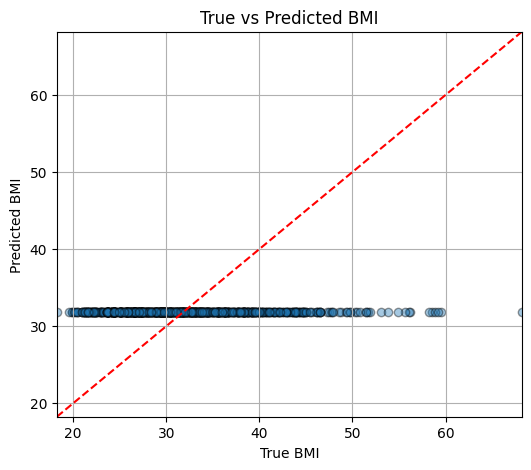

In [56]:
# Predictions
y_true = test_df[BMI_COL].values.astype('float32')
y_pred = model.predict(test_ds).flatten()

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r, _ = pearsonr(y_true, y_pred)

print(f"\nTest MAE  : {mae:.3f}")
print(f"Test RMSE : {rmse:.3f}")
print(f"Pearson r : {r:.3f}")

# Scatter
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.scatter(y_true, y_pred, alpha=.4, edgecolor='k')
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('True BMI'); plt.ylabel('Predicted BMI')
plt.title('True vs Predicted BMI')
plt.xlim(lims); plt.ylim(lims); plt.grid(True); plt.show()

In [37]:
print(model.layers[-1].activation)

<function linear at 0x789846727e20>


=== Regression Performance by Gender ===
Overall | Pearson r =  0.0755 | MAE = 5.834
Male    | Pearson r =  0.0708 | MAE = 5.616
Female  | Pearson r =  0.0857 | MAE = 6.169


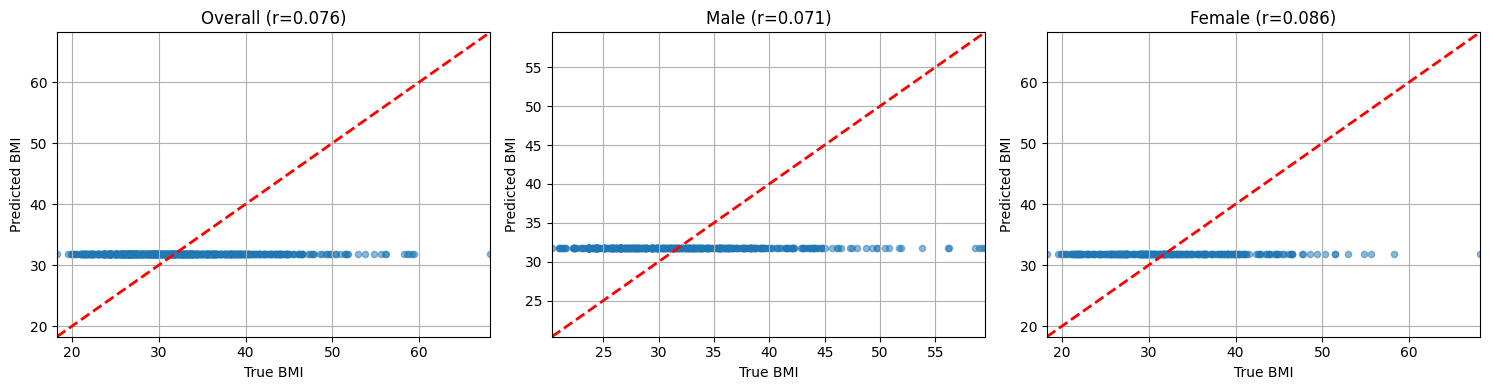

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats   import pearsonr

results = pd.DataFrame({
    'TrueBMI':     y_true,
    'PredictedBMI':y_pred,
    'gender':      test_df['gender'].values
})

groups = {
    'Overall': results,
    'Male':    results[results['gender']=='Male'],
    'Female':  results[results['gender']=='Female']
}

print("=== Regression Performance by Gender ===")
for name, df in groups.items():
    r, _  = pearsonr(df['TrueBMI'], df['PredictedBMI'])
    mae    = mean_absolute_error(df['TrueBMI'], df['PredictedBMI'])
    print(f"{name:7s} | Pearson r = {r: .4f} | MAE = {mae:.3f}")


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, df) in zip(axes, groups.items()):
    ax.scatter(df['TrueBMI'], df['PredictedBMI'], alpha=0.5, s=20)
    mn = min(df['TrueBMI'].min(), df['PredictedBMI'].min())
    mx = max(df['TrueBMI'].max(), df['PredictedBMI'].max())
    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=2)
    ax.set_title(f"{name} (r={pearsonr(df['TrueBMI'], df['PredictedBMI'])[0]:.3f})")
    ax.set_xlabel('True BMI')
    ax.set_ylabel('Predicted BMI')
    ax.set_xlim(mn, mx)
    ax.set_ylim(mn, mx)
    ax.grid(True)

plt.tight_layout()
plt.show()